Analisis Data ini menggunakan Python 3 dan Jupyter Notebook poin poin yang akan dilakukan adalah

<ul>
    <li>Cleaning data dari data yang tidak berguna (null)</li>
    <li>Mengisinya dengan data lain</li>
    <li>Menyajikan data dalam bentuk <i>plotgram</i> </li>
    <li>Membersihkan Outlier data pada <i>plotgram</i> </li>
    <li>Menambahkan Body Mass Index </li>
    <li>Menambahkan Status Ideal / Tidak Ideal </li>
</ul>

### Import File .CSV

Import data / file bentuk CSV dari S3 (AWS) atau lokal direktori kalian (saya menggunakan data Weight-Heigt.csv)

In [1]:
import boto3
import pandas as pd
from sagemaker import get_execution_role

bucket='your-bucket'
data_key = 'your-data.csv'
nama_file = 's3://{}/{}'.format(bucket, data_key)

data = pd.read_csv(nama_file)
data.head()

,ID,Gender,Height,Weight
0,1,Male,73.847017,241.893563
1,2,Male,68.781904,162.310473
2,3,Male,74.110105,212.740856
3,4,Male,71.730978,220.042470
4,5,Male,69.881796,206.349801


### Pilihlah kolom Gender, Height (dalam inch), dan Weight (dalam pound)

In [2]:
# memilih data dari beberapa kolom
data = data.filter(items=['Gender', 'Height', 'Weight'])
data.head()

,Gender,Height,Weight
0,Male,73.847017,241.893563
1,Male,68.781904,162.310473
2,Male,74.110105,212.740856
3,Male,71.730978,220.042470
4,Male,69.881796,206.349801


### Lakukan cleaning data dengan menghilangkan data null pada kedua kolom tersebut

In [3]:
data[data['Height'].isnull()]

,Gender,Height,Weight
358,Male,NaN,216.097455
369,Male,NaN,209.637975
374,Male,NaN,NaN
377,Male,NaN,165.155899


In [4]:
# menghapus baris yang mengandung null
data1 = data.dropna(axis=0, how='any')

# cek data null
data1[data1['Weight'].isnull()]

,Gender,Height,Weight


In [5]:
# mengganti data null pada 'Weight' dengan rata2nya
data2 = data.fillna(data['Weight'].mean())

# cek data null
data2[data2['Weight'].isnull()]

,Gender,Height,Weight


In [6]:
# cek data pada baris yang tadinya null pada kolom Weight
data2.loc[377]

Gender       Male
Height    161.485
Weight    165.156
Name: 377, dtype: object

### Lakukan cleaning data terhadap outlier yang ada

In [7]:
# mengidentifikasi outliers via scatter plot

import matplotlib.pyplot as plt
plt.scatter(data['Weight'], data['Height'])
plt.xlabel('Weight')
plt.ylabel('Height')
plt.show()

<Figure size 640x480 with 1 Axes>

In [8]:
# memilih data yang tidak mengandung outliers
import numpy as np

meanHeight = data['Height'].mean()
stdHeight = data['Height'].std()
meanWeight = data['Weight'].mean()
stdWeight = data['Weight'].std()

dataClean = data[(np.abs((data['Height']-meanHeight)/stdHeight) <= 2) 
                 & (np.abs((data['Weight']-meanWeight)/stdWeight) <= 2)]

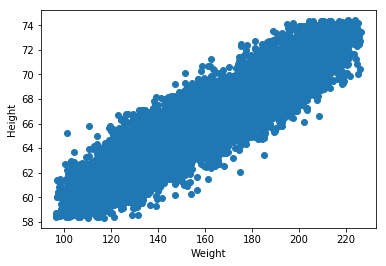

In [9]:
# scatter plot setelah menghilangkan outliers

import matplotlib.pyplot as plt
plt.scatter(dataClean['Weight'], dataClean['Height'])
plt.xlabel('Weight')
plt.ylabel('Height')
plt.show()

### Dari data hasil cleaning, buat kolom baru 'BBI' yang isinya merupakan berat badan idealnya

In [10]:
dataClean

,Gender,Height,Weight
1,Male,68.781904,162.310473
2,Male,74.110105,212.740856
3,Male,71.730978,220.042470
4,Male,69.881796,206.349801
5,Male,67.253016,152.212156
6,Male,68.785081,183.927889
7,Male,68.348516,167.971111
8,Male,67.018950,175.929440
9,Male,63.456494,156.399676
10,Male,71.195382,186.604926


In [14]:
#Rumus untuk mencari berat badan ideal dan memasukkannya pada datalist

listBBI = []

for i, data in dataClean.iterrows():
    if data['Gender'] == 'Female':
        bbi = (data['Height'] * 2.54 - 100) - (0.15 * (data['Height'] * 2.54 - 100))
    elif data['Gender'] == 'Male':
        bbi = (data['Height'] * 2.54 - 100) - (0.1 * (data['Height'] * 2.54 - 100))
    listBBI.append(bbi/0.45)

dataClean['BBI'] = listBBI
dataClean

,Gender,Height,Weight,BBI
1,Male,68.781904,162.310473,149.412073
2,Male,74.110105,212.740856,176.479335
3,Male,71.730978,220.042470,164.393370
4,Male,69.881796,206.349801,154.999523
5,Male,67.253016,152.212156,141.645320
6,Male,68.785081,183.927889,149.428213
7,Male,68.348516,167.971111,147.210459
8,Male,67.018950,175.929440,140.456264
9,Male,63.456494,156.399676,122.358989
10,Male,71.195382,186.604926,161.672542


In [40]:
#Rumus untuk mencari berat badan ideal dan memasukkannya pada datalist

listIdeal = []

for i, data in dataClean.iterrows():
    if (data['Weight'] - data['BBI'] < 20):
        idea = 'Ideal'
    else:
        idea = 'Tidak Ideal'
    listIdeal.append(idea)

dataClean['Kondisi'] = listIdeal
dataClean

,Gender,Height,Weight,BBI,Kondisi
1,Male,68.781904,162.310473,149.412073,Ideal
2,Male,74.110105,212.740856,176.479335,Tidak Ideal
3,Male,71.730978,220.042470,164.393370,Tidak Ideal
4,Male,69.881796,206.349801,154.999523,Tidak Ideal
5,Male,67.253016,152.212156,141.645320,Ideal
6,Male,68.785081,183.927889,149.428213,Tidak Ideal
7,Male,68.348516,167.971111,147.210459,Tidak Ideal
8,Male,67.018950,175.929440,140.456264,Tidak Ideal
9,Male,63.456494,156.399676,122.358989,Tidak Ideal
10,Male,71.195382,186.604926,161.672542,Tidak Ideal
